In [6]:
!pip install mplhep

In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
import random
import time
import glob
import argparse
import gc
sys.path.append('../')

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# seaborn
import seaborn as sns
from scipy.stats import pearsonr

# load custom modules required for jetCLR training
from src.modules.jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets
from src.modules.transformer import Transformer
from src.modules.losses import contrastive_loss, align_loss, uniform_loss
from src.modules.perf_eval import get_perf_stats, linear_classifier_test 

In [10]:
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

In [11]:
args.sbratio = 1
args.output_dim = 1000
args.model_dim = 1000 
args.n_heads = 4
args.dim_feedforward= 1000
args.n_layers= 4 
args.learning_rate = 0.00005 
args.n_head_layers = 2 
args.opt = "adam"
args.label = "test-aug-7-no-cmask-300"
args.load_path = f"/ssl-jet-vol-v2/JetCLR/models/experiments/{args.label}/final_model.pt"
args.trs = True
args.mask = True
args.cmask = False
args.batch_size = 128
args.trsw = 0.1
args.full_kinematics = True
args.num_files = 1
args.save_dir = f"/ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/{args.label}"
os.makedirs(args.save_dir, exist_ok=True)

## Load Data

In [12]:
def load_data(dataset_path, flag, n_files=-1):
    if args.full_kinematics:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw/data/*")
    else:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features_raw/data/*")

    data = []
    for i, file in enumerate(data_files):
        if args.full_kinematics:
            data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/data/data_{i}.npy")) 
        else:
            data.append(torch.load(f"{dataset_path}/{flag}/processed/3_features_raw/data/data_{i}.pt")) 
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data


def load_labels(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw/labels/*")

    data = []
    for i, file in enumerate(data_files):
        data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/labels/labels_{i}.npy"))
        print(f"--- loaded label file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data

In [13]:
print( "loading data")
data = load_data("/ssl-jet-vol-v2/toptagging", "test", args.num_files)
labels = load_labels("/ssl-jet-vol-v2/toptagging", "test", args.num_files)
# tr_dat_in = torch.concatenate(data, axis=0).numpy()  # Concatenate along the first axis
tr_dat_in = np.concatenate(data, axis=0)
tr_lab_in = np.concatenate(labels, axis=0)
tr_dat_in = tr_dat_in[:50000]
tr_lab_in = tr_lab_in[:50000]
print(tr_lab_in.shape)
print(tr_dat_in.shape)
# input dim to the transformer -> (pt,eta,phi)
input_dim = tr_dat_in.shape[1]
print("input_dim: ", input_dim)

loading data
--- loaded file 0 from `test` directory
--- loaded label file 0 from `test` directory
(50000,)
(50000, 7, 50)
input_dim:  7


## Splitting Data

In [14]:
def shuffle_data(tr_dat_in, tr_lab_in):
    # creating the training dataset
    print( "Splitting dataset into signal and background", flush=True )
    tr_bkg_dat = tr_dat_in[ tr_lab_in==0 ].copy()
    tr_sig_dat = tr_dat_in[ tr_lab_in==1 ].copy()
    return tr_bkg_dat, tr_sig_dat

In [15]:
tr_bkg_dat, tr_sig_dat = shuffle_data(tr_dat_in, tr_lab_in)

Splitting dataset into signal and background


In [16]:
print(tr_bkg_dat.shape, tr_sig_dat.shape)

(25220, 7, 50) (24780, 7, 50)


In [17]:
def create_validation_sets(tr_dat_in, tr_lab_in):
    """
    Splits input data and labels into two validation sets after shuffling.
    The split is 50/50, intended for use in training and testing a linear classifier.
    
    Parameters:
    - tr_dat_in: Input data, assumed to be a numpy array where each row is a data instance.
    - tr_lab_in: Corresponding input labels for the data, assumed to be a numpy array.
    
    Returns:
    - vl_dat_1: Data for the first validation set.
    - vl_lab_1: Labels for the first validation set.
    - vl_dat_2: Data for the second validation set.
    - vl_lab_2: Labels for the second validation set.
    """
    # Copy and shuffle the input data and labels
    ldz_vl = list(zip(tr_dat_in.copy(), tr_lab_in.copy()))
    random.shuffle(ldz_vl)
    
    # Unzip and convert to numpy arrays
    vl_dat, vl_lab = zip(*ldz_vl)
    vl_dat = np.array(vl_dat)
    vl_lab = np.array(vl_lab)
    
    # Calculate split index for 50/50 split
    vl_len = vl_dat.shape[0]
    vl_split_len = int(vl_len / 2)
    
    # Create and return the two validation sets
    vl_dat_1 = vl_dat[:vl_split_len]
    vl_lab_1 = vl_lab[:vl_split_len]
    vl_dat_2 = vl_dat[-vl_split_len:]
    vl_lab_2 = vl_lab[-vl_split_len:]
    
    return vl_dat_1, vl_lab_1, vl_dat_2, vl_lab_2


In [18]:
vl_dat_1, vl_lab_1, vl_dat_2, vl_lab_2 = create_validation_sets(tr_dat_in, tr_lab_in)

In [19]:
def initialize_and_load_network(input_dim, args):
    """
    Initializes a Transformer network with given parameters contained within `args`, 
    except for `input_dim` which is provided separately. Sends the network to the appropriate 
    device (CUDA if available, otherwise CPU), and loads pre-trained state from a specified 
    file path contained in `args.load_path`.

    Parameters:
    - input_dim: Dimension of the input data.
    - args: An object (e.g., argparse.Namespace) containing the following attributes:
        - model_dim: Dimensionality of the model.
        - output_dim: Dimensionality of the output.
        - n_heads: Number of attention heads in the Transformer.
        - dim_feedforward: Dimensionality of the feedforward network in the Transformer.
        - n_layers: Number of layers in the Transformer.
        - learning_rate: Learning rate for the optimizer.
        - n_head_layers: Number of head layers in the Transformer.
        - opt: Optimizer type.
        - load_path: Path from which to load the pre-trained state dictionary.
        - full_kinematics: Boolean or parameter indicating whether to use full kinematics.
        - dropout: Dropout rate for the Transformer (optional, default=0.1).
    
    Returns:
    - net: The initialized and loaded Transformer network.
    - device: The device (CUDA or CPU) to which the network has been sent.
    """
    print("initialising the network", flush=True)
    net = Transformer(input_dim, args.model_dim, args.output_dim, args.n_heads, 
                      args.dim_feedforward, args.n_layers, args.learning_rate, 
                      args.n_head_layers, dropout=0.1, opt=args.opt, 
                      log=args.full_kinematics)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.load_state_dict(torch.load(f"{args.load_path}"))
    print("All keys matched successfully")
    return net

In [20]:
net = initialize_and_load_network(input_dim, args)

initialising the network
All keys matched successfully


In [21]:
# set-up parameters for the LCT
linear_input_size = args.output_dim
linear_n_epochs = 750
linear_learning_rate = 0.001
linear_batch_size = 128

# # initialise the network
# print( "initialising the network", flush=True )
# net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt, log=args.full_kinematics )
# # send network to device
# device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
# net.to( device )
# # print(net)
# net.load_state_dict(torch.load(f"{args.load_path}"))

In [22]:
def obtain_representations(net, vl_dat_1, args):
    """
    Obtains representations from two validation datasets using the provided network,
    configured according to the given `args`. This function assumes the network has a 
    method `forward_batchwise` for processing data in batches. It marks the beginning 
    of the Linear Classifier Test (LCT) run after obtaining the representations.

    Parameters:
    - net: The neural network model to evaluate, assumed to have a `forward_batchwise` method.
    - vl_dat_1: The first set of validation data.
    - args: An object containing the following attributes:
        - batch_size: The size of the batches to use when processing the data.
        - mask: A flag indicating whether to use a mask during evaluation.
        - cmask: A flag indicating whether to use a continuous mask during evaluation.

    The function prints status updates, including when representations are being obtained
    and when the LCT is starting.
    """
    print("obtaining representations")
    gc.collect()  # Optional garbage collection before starting

    # Evaluate the network on the testing data
    with torch.no_grad():
        net.eval()  # Set the network to evaluation mode
        vl_reps_1 = net.forward_batchwise(torch.Tensor(vl_dat_1).transpose(1,2), args.batch_size, 
                                          use_mask=args.mask, use_continuous_mask=args.cmask).detach().cpu().numpy()
        net.train()  # Set the network back to training mode
    
    print("finished obtaining representations")
    return vl_reps_1


In [23]:
vl_reps_1 = obtain_representations(net, vl_dat_1, args)
vl_reps_2 = obtain_representations(net, vl_dat_2, args)

obtaining representations
finished obtaining representations
obtaining representations
finished obtaining representations


In [24]:
vl_reps_1.shape

(25000, 3, 1000)

In [37]:
def run_lct_and_plot_best_roc(vl_reps_1, vl_lab_1, vl_reps_2, vl_lab_2, linear_input_size, linear_batch_size, linear_n_epochs, linear_learning_rate):
    """
    Runs the Linear Classifier Test (LCT) multiple times for each representation layer, records AUC and IMTAFE metrics,
    selects the run with the highest AUC, and plots the ROC curve for that run.

    Parameters:
    - vl_reps_1: Validation representations set 1.
    - vl_lab_1: Validation labels set 1.
    - vl_reps_2: Validation representations set 2.
    - vl_lab_2: Validation labels set 2.
    - linear_input_size: Input size for the linear classifier.
    - linear_batch_size: Batch size for training the linear classifier.
    - linear_n_epochs: Number of epochs for training the linear classifier.
    - linear_learning_rate: Learning rate for the linear classifier.

    The function assumes the presence of `linear_classifier_test` to train the classifier,
    and `get_perf_stats` to obtain AUC and IMTAFE metrics.
    """
    best_auc = 0
    best_imtafe = 0
    best_fpr = None
    best_tpr = None

    # Run LCT for each representation layer
    for run in range(5):
        for i in range(vl_reps_1.shape[1]):
            out_dat_f, out_lbs_f, losses_f, val_losses_f = linear_classifier_test(
                linear_input_size, linear_batch_size, linear_n_epochs, "adam", linear_learning_rate, 
                vl_reps_1[:,i,:], np.expand_dims(vl_lab_1, axis=1), vl_reps_2[:,i,:], np.expand_dims(vl_lab_2, axis=1)
            )
            auc, imtafe = get_perf_stats(out_lbs_f, out_dat_f)

            # Update best AUC if current AUC is higher
            if auc > best_auc:
                best_auc = auc
                fpr, tpr, thresholds = roc_curve(out_lbs_f, out_dat_f)
                best_fpr, best_tpr = fpr, tpr
            if imtafe > best_imtafe:
                best_imtafe = imtafe

            # Optional: Print performance stats for each layer and run
            print(f"Run {run+1}, Rep Layer {i}, AUC: {round(auc, 4)}, IMTAFE: {round(imtafe, 1)}")

    # Plot the ROC curve for the run with the highest AUC
    print(f"Best AUC: {round(best_auc, 4)}, Best IMTAFE: {round(best_imtafe, 4)}")
    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % best_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Best ROC Curve across All Runs and Layers')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.4)
    plt.savefig(f"{args.save_dir}/roc.png")
    plt.show()


In [101]:
run_lct_and_plot_best_roc(vl_reps_1, vl_lab_1, vl_reps_2, vl_lab_2, linear_input_size, linear_batch_size, linear_n_epochs, linear_learning_rate)

Device 0: NVIDIA GeForce RTX 3090
9.24907
Run 1, Rep Layer 0, AUC: 0.9672, IMTAFE: 68.5
Device 0: NVIDIA GeForce RTX 3090


KeyboardInterrupt: 

## PCA

In [43]:
def do_pca(X):
    # Assuming X is your 1000-dimensional dataset with shape (n_samples, 1000)
    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    
    # Step 2: Apply PCA to reduce dimensionality to 8 components
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X_standardized)
    # Now X_pca has the transformed data in the reduced dimensionality space
    return X_pca

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def do_pca_multirep(X):
    """
    Applies PCA to reduce the dimensionality of a dataset with multiple sets of features (representations)
    for each sample. The input is a tensor/array of shape (num_samples, num_reps, num_features), and the output
    is of shape (num_samples, num_reps, 8), where each set of features is reduced to 8 principal components.

    Parameters:
    - X: A numpy array or tensor with shape (num_samples, num_reps, num_features) representing the dataset
         with multiple representations for each sample.

    Returns:
    - X_pca: A numpy array with shape (num_samples, num_reps, 8) where the dimensionality of each set of
             features has been reduced to 8 principal components.
    """
    num_samples, num_reps, num_features = X.shape
    X_pca = np.zeros((num_samples, num_reps, 8))  # Prepare the output array
    
    for rep in range(num_reps):
        # Extract the current set of representations
        X_rep = X[:, rep, :]
        
        # Standardize the data
        scaler = StandardScaler()
        X_rep_standardized = scaler.fit_transform(X_rep)
        
        # Apply PCA to reduce dimensionality to 8 components
        pca = PCA(n_components=8)
        X_rep_pca = pca.fit_transform(X_rep_standardized)
        
        # Store the reduced data in the output array
        X_pca[:, rep, :] = X_rep_pca
    
    return X_pca


## Pair Plots

In [26]:
data_qcd, data_top = shuffle_data(tr_dat_in, tr_lab_in)

Splitting dataset into signal and background


In [27]:
data_qcd.shape

(25220, 7, 50)

In [31]:
# do PCA
reps_top_full = obtain_representations(net, data_top, args)
reps_qcd_full = obtain_representations(net, data_qcd, args)
# do PCA
reps_top_full_pca = do_pca_multirep(reps_top_full)
reps_qcd_full_pca = do_pca_multirep(reps_qcd_full)
# just want to use the 0th rep (i.e. directly from the transformer) for now
reps_top = reps_top_full[:, 1, :]
reps_qcd = reps_qcd_full[:, 1, :]
reps_top_pca = reps_top_full_pca[:, 1, :]
resp_qcd_pca = reps_qcd_full_pca[:, 1, :]

In [29]:
reps_top.shape

(24780, 3, 1000)

In [30]:
reps_qcd.shape

(25220, 3, 1000)

In [32]:
reps_qcd_pca.shape

(25220, 3, 8)

In [27]:
def mean_pearson_coefficient(data):
    """
    Calculates the mean Pearson correlation coefficient across all unique pairs of features in the dataset.

    Parameters:
    - data: A 2D numpy array where rows represent samples and columns represent features.

    Returns:
    - mean_corr: The mean Pearson correlation coefficient across all unique feature pairs.
    """
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_tri = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
    
    # Compute the mean of the upper triangular values
    mean_corr = np.mean(upper_tri)
    
    return mean_corr

In [29]:
mean_pearson_coefficient(reps_top)

0.12573547842005914

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_pair_plots(data, args, flag):
    """
    Generates pair plots for the QCD dataset, including histograms on the diagonal 
    and scatter plots with Pearson correlation coefficients for off-diagonal elements.
    
    Parameters:
    - data: A numpy array where rows represent samples and columns represent features.
    - args
    - flag: QCD or Top
    
    Saves the generated plot to the specified path constructed from the provided parameters.
    """
    num_feats = data.shape[1]
    fig, axs = plt.subplots(num_feats, num_feats, figsize=(30, 30))  # Increase figure size

    for i in range(num_feats):
        for j in range(i + 1):
            # Compute Pearson correlation coefficient using scipy
            corr_coeff, _ = pearsonr(data[:, i], data[:, j])
            
            # Diagonal histograms
            if i == j:
                axs[i, j].hist(data[:, i], bins=20, color='skyblue', edgecolor='black')
                axs[i, j].set_yticklabels([])
                axs[i, j].set_xticklabels([])
            else:
                # Scatter plot for off-diagonal
                axs[i, j].scatter(data[:, j], data[:, i], s=5)
                axs[i, j].set_title(f"{corr_coeff:.2f}", fontsize=8, pad=-15)  # Decrease font size
                axs[i, j].set_yticklabels([])
                axs[i, j].set_xticklabels([])
                axs[j, i].axis('off')  # Hide the upper part of the matrix

    fig.suptitle(f'{flag} Pair Plots', fontsize=20)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing between subplots
    save_path = f"{args.save_dir}/{flag}_pair_plots.png"
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Pair plots saved to: {save_path}")


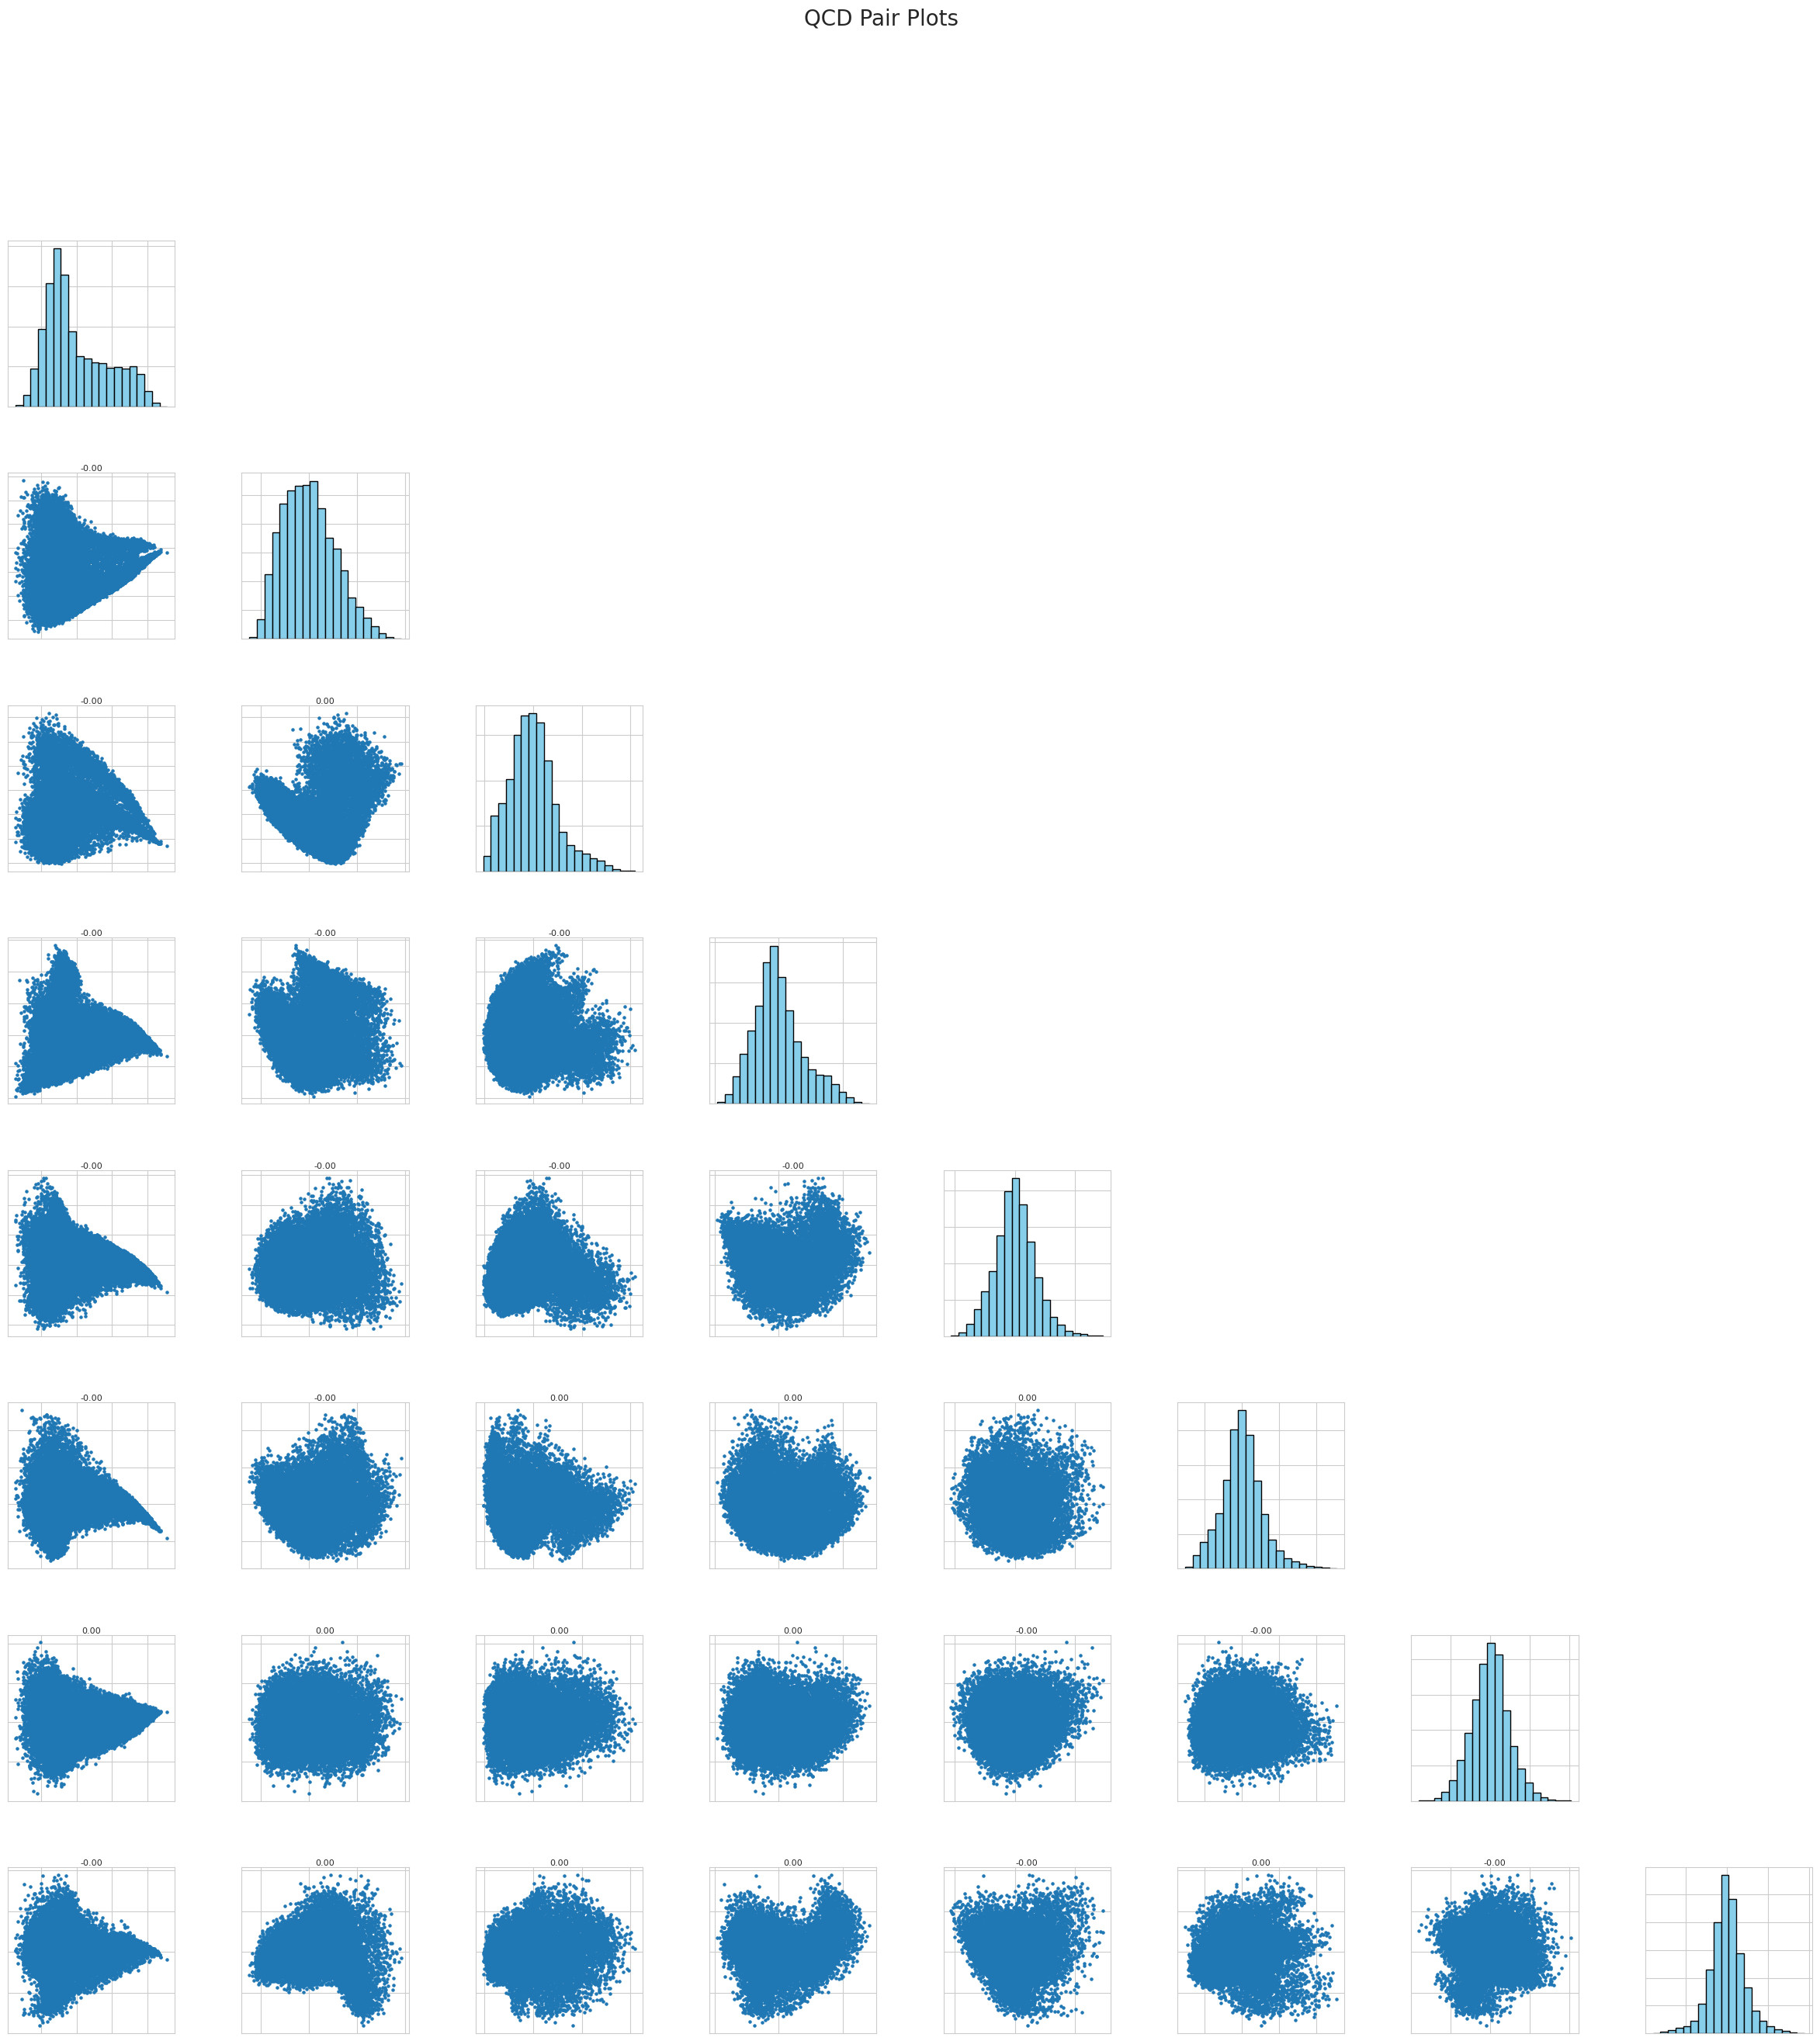

Pair plots saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/QCD_pair_plots.png


In [45]:
plot_pair_plots(reps_qcd_pca, args, "QCD")

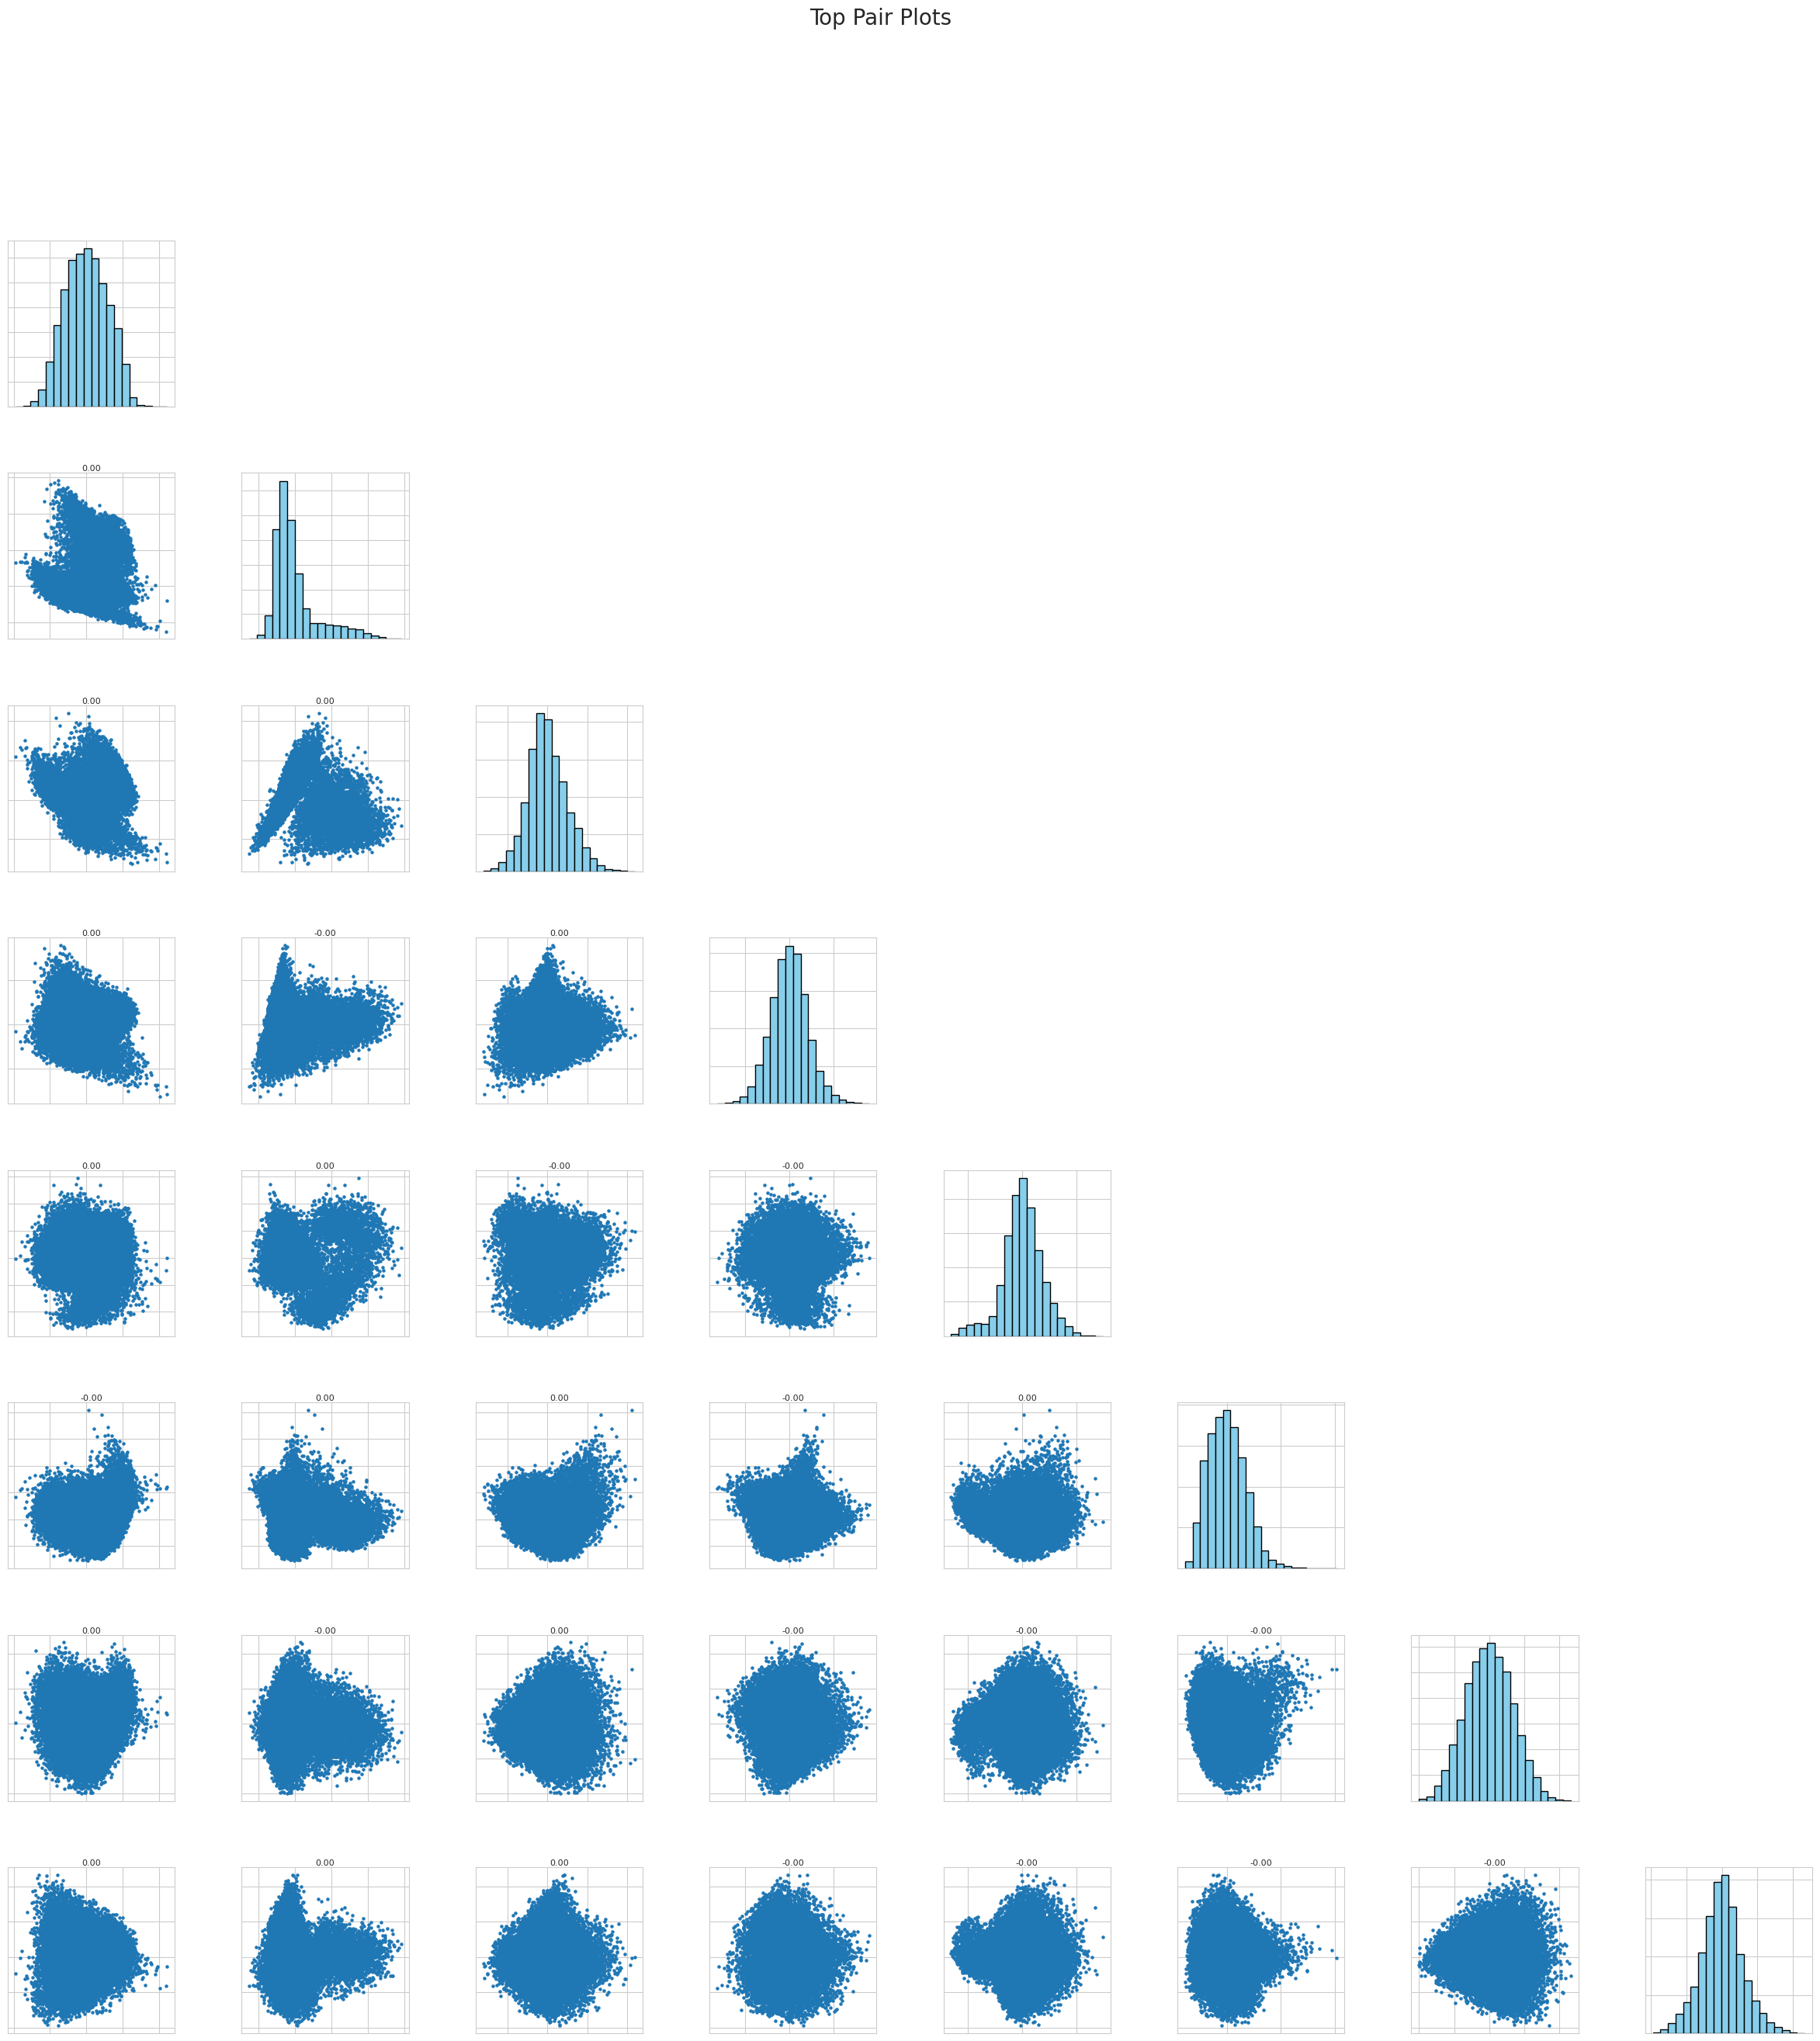

Pair plots saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/Top_pair_plots.png


In [46]:
plot_pair_plots(reps_top_pca, args, "Top")

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_and_qcd_features(data_top, data_qcd, args):
    """
    Generates histograms for each feature from two datasets, 'top' and 'QCD',
    on the same canvas for direct comparison.

    Parameters:
    - data_top: A numpy array for the 'top' dataset where rows represent samples and columns represent features.
    - data_qcd: A numpy array for the 'QCD' dataset where rows represent samples and columns represent features.
    """
    num_feats = data_qcd.shape[1]
    num_columns = 2
    num_rows = int(np.ceil(num_feats / num_columns))

    # Adjust the figure height for each subplot
    height_per_subplot = 2
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * height_per_subplot))

    # Style settings
    sns.set_style("whitegrid")
    colors = ['blue', 'red']

    for i in range(num_feats):
        row = i // num_columns
        col = i % num_columns
        ax = axs[row, col] if num_rows > 1 else axs[col]

        sns.histplot(data_top[:, i], bins=50, ax=ax, color=colors[0], label='Top', alpha=0.6)
        sns.histplot(data_qcd[:, i], bins=50, ax=ax, color=colors[1], label='QCD', alpha=0.6)

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_title(f"PCA Feature {i}")
        ax.legend()

        sns.despine(ax=ax)

    # If the number of features isn't a multiple of the columns, remove unused subplots
    if num_feats % num_columns != 0:
        for j in range(num_feats, num_rows * num_columns):
            axs.flatten()[j].axis('off')

    fig.suptitle('Top and QCD Feature Comparison', y=1.02)
    plt.tight_layout(pad=2.0)
    save_path = f"{args.save_dir}/Top_and_QCD Feature_Comparison.png"
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Comparison plots saved to: {save_path}")


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

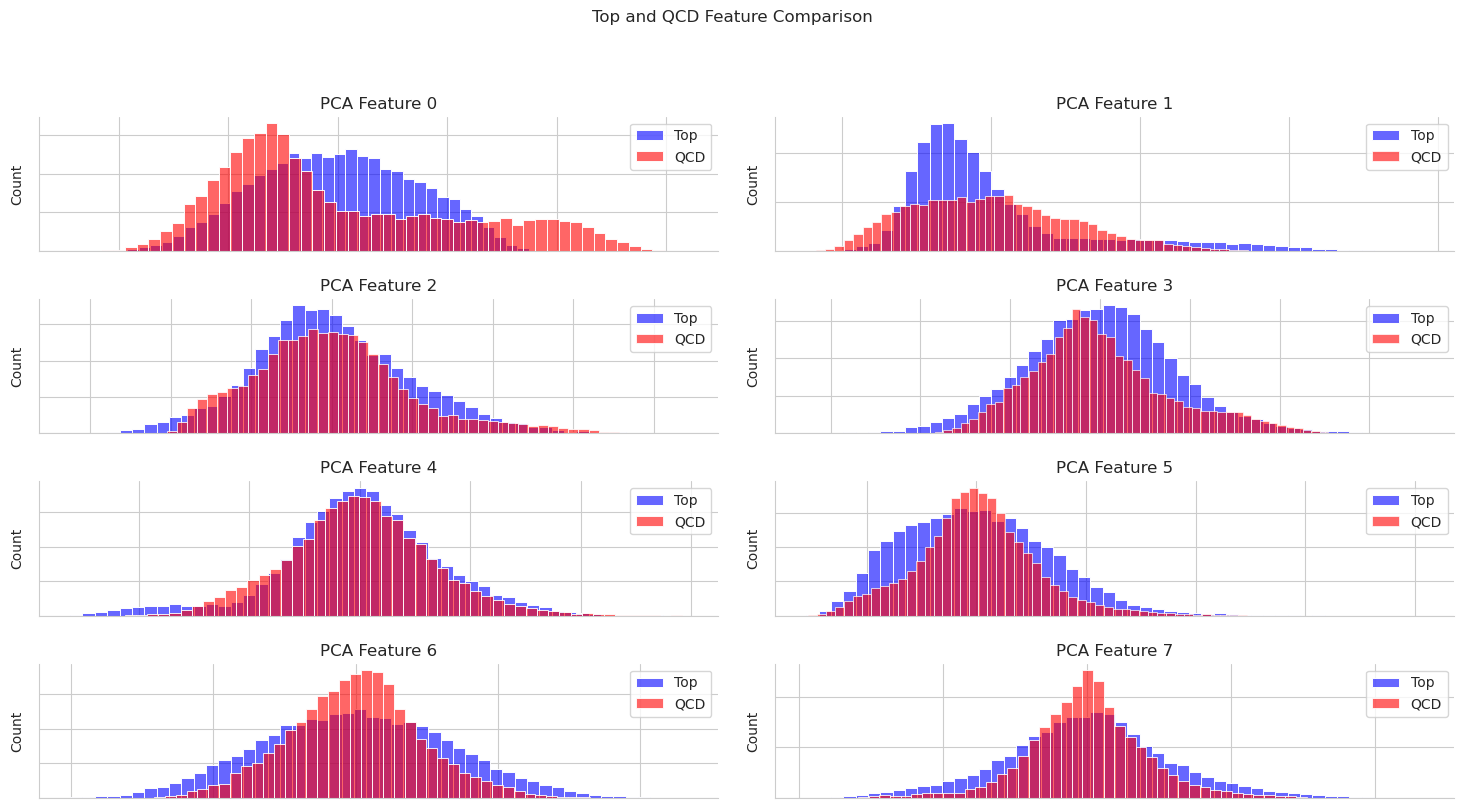

Comparison plots saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/Top_and_QCD Feature_Comparison.png


In [51]:
plot_top_and_qcd_features(reps_top_pca, reps_qcd_pca, args)

## t-SNE

In [52]:
data_numpy = obtain_representations(net, tr_dat_in, args)[:, 1, :]

obtaining representations
finished obtaining representations


In [57]:
reps_full = obtain_representations(net, tr_dat_in, args)[:, 1, :]

obtaining representations
finished obtaining representations


In [58]:
reps_full.shape

(50000, 1000)

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_visualization(data_numpy, labels_numpy, save_dir, perplexity=30, n_iter=300, s=1):
    """
    Applies t-SNE to the provided dataset and plots the 2D visualization,
    differentiating points by labels ('top' and 'QCD').

    Parameters:
    - data_numpy: A numpy array where rows represent samples and columns represent features.
    - labels_numpy: A numpy array of labels corresponding to the samples in data_numpy.
    - save_dir: Directory where the plot image will be saved.
    - perplexity: The perplexity hyperparameter for t-SNE (default 30).
    - n_iter: The number of iterations for optimization in t-SNE (default 300).
    - s: Size of the points in the scatter plot (default 1).
    """
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(data_numpy)

    # Separate points by labels
    top_points = tsne_results[labels_numpy == 1]
    qcd_points = tsne_results[labels_numpy == 0]

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(top_points[:, 0], top_points[:, 1], color='b', alpha=0.5, label='Top', s=s)
    plt.scatter(qcd_points[:, 0], qcd_points[:, 1], color='r', alpha=0.5, label='QCD', s=s)
    plt.title("t-SNE Visualization of Jet Features")
    plt.legend(loc='upper right')
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.grid(b=False)
    
    # Save and show plot
    save_path = f"{save_dir}/t-SNE.png"
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"t-SNE plots saved to: {save_path}")


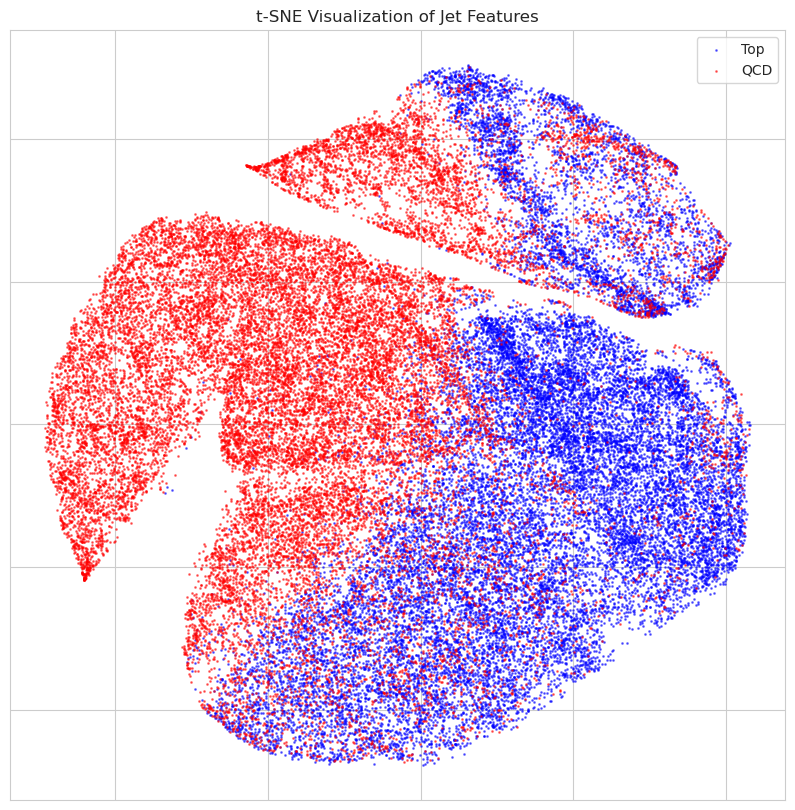

t-SNE plots saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/t-SNE.png


In [60]:
plot_tsne_visualization(reps_full, tr_lab_in, args.save_dir)

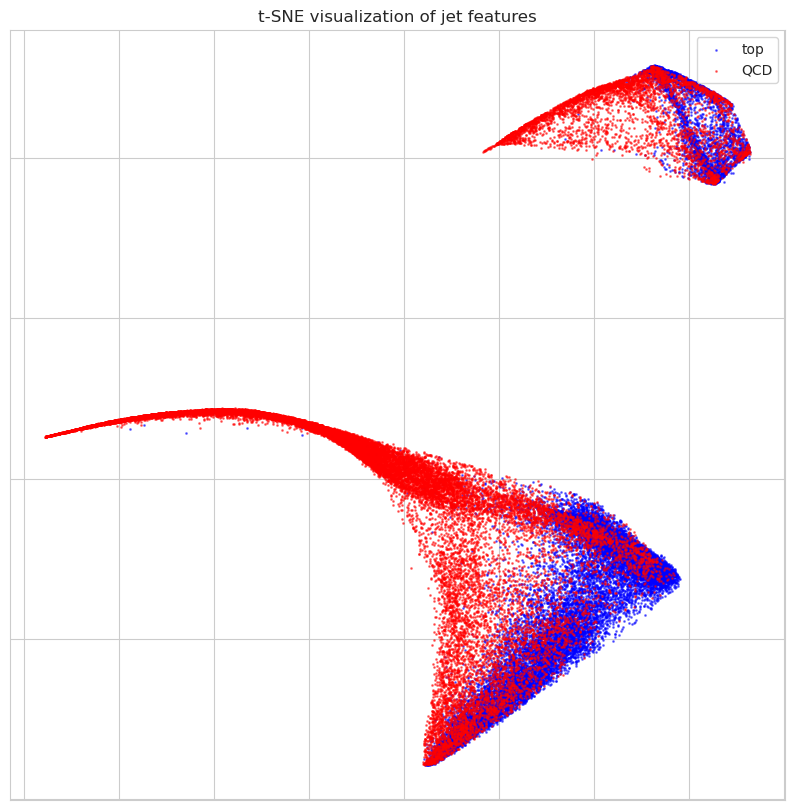

t-SNE plots saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/t-SNE.png


In [56]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=250)  # you can change these hyperparameters as needed
tsne_results = tsne.fit_transform(data_numpy)

# tsne_results now has a shape of [num_samples, 2], and you can plot it

labels_numpy = tr_lab_in
# Use boolean indexing to separate points for each label
top_points = tsne_results[labels_numpy == 1]
qcd_points = tsne_results[labels_numpy == 0]

plt.figure(figsize=(10, 10))
ax = plt.gca()
# Plot each class with a different color and label
plt.scatter(top_points[:, 0], top_points[:, 1], color='b', alpha=0.5, label='top', s=1)
plt.scatter(qcd_points[:, 0], qcd_points[:, 1], color='r', alpha=0.5, label='QCD', s=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("t-SNE visualization of jet features")
plt.legend(loc='upper right')  # place the legend at the upper right corner
save_path = f"{args.save_dir}/t-SNE.png"
plt.savefig(save_path)
plt.show()
plt.close()
print(f"t-SNE plots saved to: {save_path}")


In [36]:
vl_reps_1.shape

(25000, 3, 1000)

In [34]:
vl_reps_1_pca = do_pca_multirep(vl_reps_1)
vl_reps_2_pca = do_pca_multirep(vl_reps_2)

In [35]:
vl_reps_1_pca.shape

(25000, 3, 8)

Device 0: NVIDIA GeForce GTX 1080 Ti
0.28557217
Run 1, Rep Layer 0, AUC: 0.9068, IMTAFE: 14.3
Device 0: NVIDIA GeForce GTX 1080 Ti
0.28253585
Run 1, Rep Layer 1, AUC: 0.9071, IMTAFE: 14.2
Device 0: NVIDIA GeForce GTX 1080 Ti
0.60165006
Run 1, Rep Layer 2, AUC: 0.5888, IMTAFE: 2.4
Device 0: NVIDIA GeForce GTX 1080 Ti
0.28254846
Run 2, Rep Layer 0, AUC: 0.9052, IMTAFE: 13.8
Device 0: NVIDIA GeForce GTX 1080 Ti
0.28287572
Run 2, Rep Layer 1, AUC: 0.9063, IMTAFE: 13.6
Device 0: NVIDIA GeForce GTX 1080 Ti
0.6026428
Run 2, Rep Layer 2, AUC: 0.5853, IMTAFE: 2.4
Device 0: NVIDIA GeForce GTX 1080 Ti
0.2832222
Run 3, Rep Layer 0, AUC: 0.9082, IMTAFE: 14.3
Device 0: NVIDIA GeForce GTX 1080 Ti
0.28135654
Run 3, Rep Layer 1, AUC: 0.9067, IMTAFE: 14.3
Device 0: NVIDIA GeForce GTX 1080 Ti
0.6009041
Run 3, Rep Layer 2, AUC: 0.5873, IMTAFE: 2.4
Device 0: NVIDIA GeForce GTX 1080 Ti
0.28205988
Run 4, Rep Layer 0, AUC: 0.9071, IMTAFE: 14.3
Device 0: NVIDIA GeForce GTX 1080 Ti
0.2821964
Run 4, Rep Layer 1,

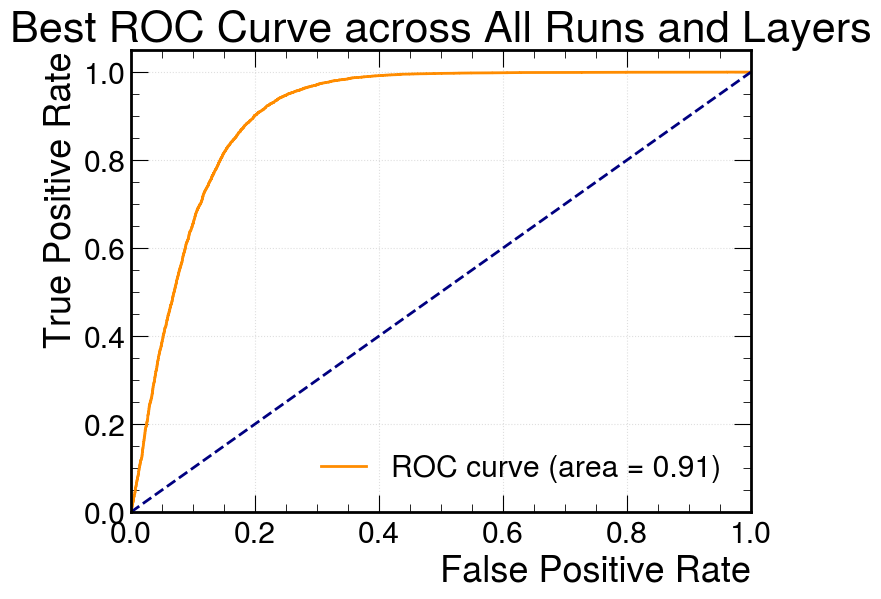

In [40]:
run_lct_and_plot_best_roc(vl_reps_1_pca, vl_lab_1, vl_reps_2_pca, vl_lab_2, 8, linear_batch_size, linear_n_epochs, linear_learning_rate)

## Plot Losses

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_and_plot_metrics(args):
    """
    Attempts to load various metric arrays from specified paths based on a label,
    plots each metric if available, adding X and Y axis labels, and saves each plot to a designated directory.

    Parameters:
    - args
        - label: The label that identifies the experiment.
        - save_dir: The directory where the plots will be saved.
    """
    label = args.label
    save_dir = args.save_dir
    base_path = f"/ssl-jet-vol-v2/JetCLR/models/experiments/{label}/"
    metrics = {
        "auc_epochs": ("LCT AUC vs epochs", "Epochs", "AUC"),
        "imtafe_epochs": ("LCT imtafe vs epochs", "Epochs", "IMTAFE"),
        "align_loss_train": ("Alignment loss vs epochs", "Epochs", "Alignment Loss"),
        "clr_losses": ("Total CLR losses vs epochs", "Epochs", "CLR Loss"),
        "uniform_loss_train": ("Uniform loss vs epochs", "Epochs", "Uniform Loss"),
        "val_losses": ("Validation losses vs epochs", "Epochs", "Validation Loss")
    }
    
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for metric_name, (plot_title, xlabel, ylabel) in metrics.items():
        try:
            metric_values = np.load(base_path + f"{metric_name}.npy")
            plt.figure()
            plt.plot(metric_values)
            plt.title(plot_title)
            plt.xlabel(xlabel)  # Set X axis label
            plt.ylabel(ylabel)  # Set Y axis label
            
            save_path = os.path.join(save_dir, f"{metric_name}.png")
            plt.savefig(save_path)
            plt.close()
            print(f"Plot saved to: {save_path}")
        except IOError as e:
            print(f"Error loading {metric_name}.npy: {e}")


In [71]:
load_and_plot_metrics(args)

Plot saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/auc_epochs.png
Plot saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/imtafe_epochs.png
Plot saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/align_loss_train.png
Plot saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/clr_losses.png
Plot saved to: /ssl-jet-vol-v2/JetCLR/models/model_performances/Top_Tagging/test-aug-7-no-cmask-300/uniform_loss_train.png
Error loading val_losses.npy: [Errno 2] No such file or directory: '/ssl-jet-vol-v2/JetCLR/models/experiments/test-aug-7-no-cmask-300/val_losses.npy'
